In [92]:
import gzip
import shutil
import os
from PIL import Image

# 数据准备

## 数据解压

In [93]:
data_folder = "../data"

for file_name in os.listdir(data_folder):
    if file_name.endswith(".gz"):
        file_path = os.path.join(data_folder, file_name)
        out_path = file_path.replace(".gz", "")  # 解压后的文件路径

        # 解压文件
        with gzip.open(file_path, 'rb') as in_file:
            with open(out_path, 'wb') as out_file:
                shutil.copyfileobj(in_file, out_file)

## 读取用于训练&测试的图片&标签数据

In [94]:
import numpy as np


def load_images(file_path):
    """ 载入图片数据 """
    with open(file_path, 'rb') as f:
        f.read(16)  # 根据MNIST数据集格式，跳过元数据
        data = np.frombuffer(f.read(), dtype=np.uint8)
        data = data.reshape(-1, 28, 28)  # 每张图片为 28x28 的灰度值图片
    return data


def load_labels(file_path):
    """ 载入标签数据 """
    with open(file_path, 'rb') as f:
        f.read(8)  # 根据MNIST数据集格式，跳过元数据
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

In [95]:
train_images = load_images(data_folder + "/train-images-idx3-ubyte")
train_labels = load_labels(data_folder + "/train-labels-idx1-ubyte")
test_images = load_images(data_folder + "/t10k-images-idx3-ubyte")
test_labels = load_labels(data_folder + "/t10k-labels-idx1-ubyte")

可视化数据集看看：

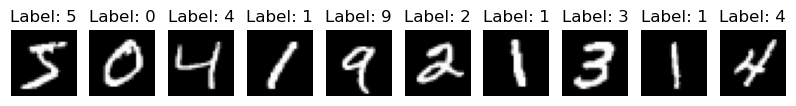

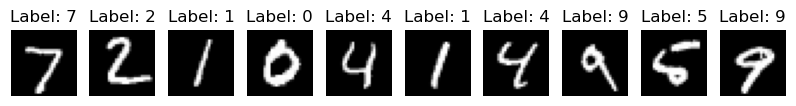

In [96]:
import matplotlib.pyplot as plt


def visualize(images, labels, num_samples=10):
    plt.figure(figsize=(10, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()


# 可视化训练集的前10张图像
visualize(train_images, train_labels)

# 可视化测试集的前10张图像
visualize(test_images, test_labels)

## 数据预处理：为后续输入MLP做准备

把数据放到tensor中

In [97]:
import torch

my_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_images_tensor = torch.tensor(train_images, dtype=torch.float32, device=my_device)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long, device=my_device)
test_images_tensor = torch.tensor(test_images, dtype=torch.float32, device=my_device)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long, device=my_device)

将图片数据展平并归一化

In [98]:
train_images_tensor =  train_images_tensor.flatten(start_dim=1) / 255.0
test_images_tensor = test_images_tensor.flatten(start_dim=1) / 255.0

In [99]:
len(train_images_tensor)
train_images_tensor.device

device(type='cuda', index=0)

实现Dataset、DataLoader类来包装数据

In [100]:
class MyDataset:
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, id):
        return self.images[id], self.labels[id]
    
    
class MyDataLoader:
    def __init__(self, dataset, batch_size=1, shuffle=False, device='cpu'):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.ids = np.arange(len(dataset))  # 索引列表
        self.cur_id = 0
        self.device = device

    def __iter__(self):
        self.cur_id = 0  # 重置索引
        if self.shuffle:
            np.random.shuffle(self.ids)  # 打乱索引
        return self
    
    def __next__(self):
        if self.cur_id >= len(self.dataset):
            raise StopIteration
        
        # 获取一个batch的索引
        batch_ids = self.ids[self.cur_id : self.cur_id + self.batch_size]
        
        # 获取一个batch的对应数据
        batch_data = [self.dataset[i] for i in batch_ids]
        
        # 返回一个batch的图片和标签（并改为tensor类型）
        images, labels = zip(*batch_data)
        images = torch.stack(images).to(self.device)
        labels = torch.tensor(labels).to(self.device)
        self.cur_id += self.batch_size
        return images, labels

    def __len__(self):
        """ 数据集的大小，即总批次数量 """
        return int(np.ceil(len(self.dataset) / self.batch_size)) 

In [101]:
train_set = MyDataset(train_images_tensor, train_labels_tensor)
test_set = MyDataset(test_images_tensor, test_labels_tensor)

train_loader = MyDataLoader(train_set, batch_size=32, shuffle=True, device=my_device)
test_loader = MyDataLoader(test_set, batch_size=32, shuffle=False, device=my_device)

# 模型实现

实现线性层、激活函数、损失函数等组件

In [102]:
class MyLinear():
    """ 线性变换层
    
    Args:
        input_size (int): 输入特征的数量
        output_size (int): 输出特征的数量
        
    Examples:
        >>> input = torch.randn(128, 20)
        >>> m = MyLinear(20, 30)
        >>> output = m.forward(input)
        >>> print(output.size())
        torch.Size([128, 30])
    """
    def __init__(self, input_size, output_size, device="cpu"):
        # 正态随机初始化权重和偏置
        self.device = device
        self.weights = torch.randn(output_size, input_size, device=self.device)
        self.bias = torch.randn(output_size, device=self.device)

    def forward(self, x):
        """ 前向传播 """
        self.x = x.to(self.device)
        y = torch.matmul(x, self.weights.T) + self.bias
        return y
    
    def backward(self, grad_out):
        """ 反向传播 """
        self.grad_weights = torch.matmul(grad_out.T, self.x)
        self.grad_bias = torch.sum(grad_out, dim=0)
        grad_in = torch.matmul(grad_out, self.weights)
        return grad_in

    def update(self, lr):
        """ 更新参数 """
        self.weights = self.weights - lr * self.grad_weights
        self.bias = self.bias - lr * self.grad_bias

In [103]:
m = MyLinear(20, 30)
input = torch.randn(128, 20)
probs = m.forward(input)
print(probs.size())

torch.Size([128, 30])


In [104]:
class ReLU:
    def forward(self, x):
        self.x = x  # 保存输入以便后向传播使用
        y = torch.maximum(x, torch.tensor(0.0))
        return y
    
    def backward(self, grad_out):
        grad_in = grad_out.clone()
        grad_in[self.x <= 0] = 0  # 对于非正的输入，梯度为零
        return grad_in

In [105]:
class Softmax:
    def __init__(self, device="cpu"):
        self.device = device

    def forward(self, x):
        x_max = torch.max(x, dim=1, keepdim=True) # 防止溢出，减去最大值来增加数值稳定性
        x_exp = torch.exp(x - x_max.values)
        self.probs = x_exp / torch.sum(x_exp, dim=1, keepdim=True)
        return self.probs
    
    def cross_entropy(self, predictions, truths):
        probs = self.probs  # Softmax得到的预测标签的概率分布

        # 设定一个最小值min_val，防止log(0)
        min_val = 1e-6
        probs = torch.where(probs < min_val, torch.full_like(probs, min_val), probs)

        # 计算交叉熵损失
        batch_size = predictions.shape[0]
        truth_onehot = torch.zeros(batch_size, probs.shape[1], device=self.device)
        truth_onehot[torch.arange(batch_size), truths] = 1
        loss = -torch.mean(torch.sum(truth_onehot * torch.log(probs), dim=1))

        self.batch_size = batch_size  # 批次大小
        self.truth_onehot = truth_onehot  # 真实标签的one-hot分布

        return loss

    def backward(self):
        grad_in = (self.probs - self.truth_onehot) / self.batch_size
        return grad_in


实现一个包含单隐藏层的前馈神经网络

In [106]:
class MLP:
    def __init__(self, input_size, hidden_size, output_size, device="cpu"):
        """ 初始化单隐藏层网络 """
        self.fc1 = MyLinear(input_size, hidden_size, device)  # 输入到隐藏层的线性变换
        self.relu = ReLU()  # 隐藏层激活函数
        self.fc2 = MyLinear(hidden_size, output_size, device)  # 隐藏层到输出层的线性变换
        self.softmax = Softmax(device)  # 输出层的 Softmax 激活
        self.device = device
    
    def forward(self, x):
        """ 前向传播 """
        x = self.fc1.forward(x)  
        x = self.relu.forward(x)  
        x = self.fc2.forward(x)  
        x = self.softmax.forward(x)  
        return x

    def backward(self):
        """ 反向传播 """
        grad = self.softmax.backward()
        grad = self.fc2.backward(grad)
        grad = self.relu.backward(grad)
        grad = self.fc1.backward(grad)

    def update(self, lr):
        """ 更新参数 """
        self.fc1.update(lr)
        self.fc2.update(lr)

    def save(self, file_path):
        """ 保存模型参数 """
        model_params = {
            "fc1_weights": self.fc1.weights,
            "fc1_bias": self.fc1.bias,
            "fc2_weights": self.fc2.weights,
            "fc2_bias": self.fc2.bias,
        }
        torch.save(model_params, file_path)
        print(f"模型参数已保存到 {file_path}")

    def load(self, file_path):
        """ 加载模型参数 """
        model_params = torch.load(file_path, weights_only=True)
        self.fc1.weights = model_params["fc1_weights"]
        self.fc1.bias = model_params["fc1_bias"]
        self.fc2.weights = model_params["fc2_weights"]
        self.fc2.bias = model_params["fc2_bias"]
        print(f"模型参数已从 {file_path} 加载")

    def predict(self, img_path):
        """ 利用模型识别图片中的数字 """
        # 打开图片并将其转化为灰度图
        img = Image.open(img_path).convert("L") 
        img = img.resize((28, 28))

        # 将图片转化为tensor
        img_np = np.array(img)
        img_np = 255 - img_np  # 由于MNIST训练数据是黑底白字，这里也需要转化一下
        img_tensor = torch.tensor(img_np, dtype=torch.float, device=self.device)
        img_tensor = img_tensor.flatten(start_dim=0) / 255.0  # 展平+归一化
        img_tensor = img_tensor.unsqueeze(0)  # 添加一个batch维度，形状(1, 748)

        # 获取预测结果（概率分布）
        probs = self.forward(img_tensor)

        # 获取预测标签
        predicted_label = torch.argmax(probs, dim=1).item()
        return predicted_label

训练函数

In [107]:
def train_and_evaluate(model, train_loader, test_loader, epochs, learning_rate):
    train_loss_history = []
    test_loss_history = []
    
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            probs = model.forward(images)  # 前向传播
            loss = model.softmax.cross_entropy(probs, labels)  # 计算损失
            model.backward()  # 反向传播
            model.update(learning_rate)  # 更新参数
            total_loss += loss.item()
        
        # 计算平均训练损失
        avg_train_loss = total_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)
        
        # 评估模型在测试集上的准确率
        accuracy, avg_test_loss = evaluate(model, test_loader)
        test_loss_history.append(avg_test_loss)

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Test Accuracy: {(accuracy * 100):.4f}%")
        
    # 绘制曲线
    plt.figure(figsize=(10, 6))
    plt.plot(range(epochs), train_loss_history, label='Train Loss')
    plt.plot(range(epochs), test_loss_history, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Test Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


def evaluate(model, test_loader):
    correct = 0
    total = 0
    total_test_loss = 0
    
    for images, labels in test_loader:
        probs = model.forward(images)
        loss = model.softmax.cross_entropy(probs, labels)
        total_test_loss += loss.item()
        
        # 获取预测的类别
        _, predicted = torch.max(probs, dim=1)  # 输出每行最大值的索引，即预测的类别
        
        # 统计正确预测的数量
        correct += (predicted == labels).sum().item()
        total += labels.size(0)  
    
    accuracy = correct / total  # 计算准确率
    avg_test_loss = total_test_loss / len(test_loader)
    
    return accuracy, avg_test_loss


Epoch 1/20, Train Loss: 1.0135, Test Accuracy: 94.6300%
Epoch 2/20, Train Loss: 0.3637, Test Accuracy: 95.2500%
Epoch 3/20, Train Loss: 0.1952, Test Accuracy: 95.5700%
Epoch 4/20, Train Loss: 0.1093, Test Accuracy: 96.1400%
Epoch 5/20, Train Loss: 0.0515, Test Accuracy: 96.3800%
Epoch 6/20, Train Loss: 0.0257, Test Accuracy: 96.3900%
Epoch 7/20, Train Loss: 0.0126, Test Accuracy: 96.4500%
Epoch 8/20, Train Loss: 0.0077, Test Accuracy: 96.5300%
Epoch 9/20, Train Loss: 0.0031, Test Accuracy: 96.6300%
Epoch 10/20, Train Loss: 0.0017, Test Accuracy: 96.6800%
Epoch 11/20, Train Loss: 0.0016, Test Accuracy: 96.6900%
Epoch 12/20, Train Loss: 0.0006, Test Accuracy: 96.8500%
Epoch 13/20, Train Loss: 0.0002, Test Accuracy: 96.8200%
Epoch 14/20, Train Loss: 0.0001, Test Accuracy: 96.8200%
Epoch 15/20, Train Loss: 0.0001, Test Accuracy: 96.8200%
Epoch 16/20, Train Loss: 0.0001, Test Accuracy: 96.8200%
Epoch 17/20, Train Loss: 0.0001, Test Accuracy: 96.8200%
Epoch 18/20, Train Loss: 0.0001, Test Ac

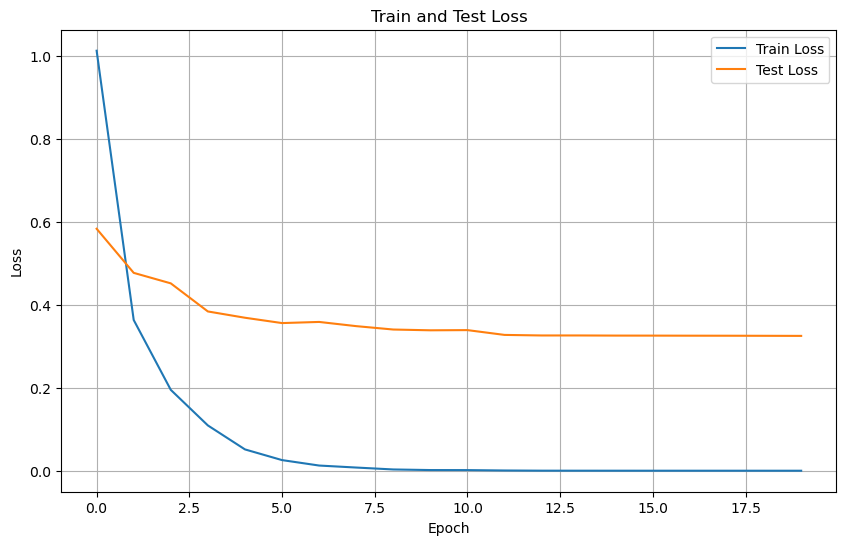

In [108]:
# 训练和评估
input_size = 784
hidden_size = 1024
output_size = 10
n_epochs = 20
lr = 0.1
batch_size = 16

train_loader = MyDataLoader(train_set, batch_size, shuffle=True, device=my_device)
test_loader = MyDataLoader(test_set, batch_size, shuffle=False, device=my_device)

model = MLP(input_size, hidden_size, output_size, my_device)

train_and_evaluate(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=n_epochs,
    learning_rate=lr
)

#### 保存模型参数

In [109]:
model.save("./models/model0.pth")

模型参数已保存到 ./models/model0.pth


#### 载入模型参数并测试识别效果

In [110]:
newModel = MLP(input_size=748, hidden_size=1024, output_size=10, device=my_device)
newModel.load("./models/model0.pth")

模型参数已从 ./models/model0.pth 加载


In [111]:
def show_img(img_path):
    img = Image.open(img_path)
    img = img.resize((28, 28))
    return img

In [112]:
show_img("../data/handwrite_3.png")

In [113]:
model.predict("../data/handwrite_3.png")

3

In [114]:
show_img("../data/test_num4.jpg")

In [115]:
model.predict("../data/test_num4.jpg")

8

In [116]:
show_img("../data/test_num5.jpg")

In [117]:
model.predict("../data/test_num5.jpg")

5

In [118]:
show_img("../data/test_num6.jpg")

In [119]:
model.predict("../data/test_num6.jpg")

6

In [120]:
show_img("../data/test_num7.jpg")

In [121]:
newModel.predict("../data/test_num7.jpg")

2

In [122]:
show_img("../data/test_num8.jpg")

In [123]:
model.predict("../data/test_num8.jpg")

8

In [124]:
show_img("../data/test_num9.jpg")

In [125]:
newModel.predict("../data/test_num9.jpg")

9

In [126]:
show_img("../data/test_num0.jpg")

In [127]:
newModel.predict("../data/test_num0.jpg")

0